# Sentiment Analysis of Tweets of Major US Airlines.

### <b>Classifying a tweet as positive, neutral or negative sentiment using Natural Language Processing and Traditional Machine Learning Algorithms.</b>

The evaluation metric for this use case is Macro F-Score.

Highlights - 
- Reg-Ex functions have been used to pre-process the tweets.
- To convert tokens to text, we have used only sparse vectors (bag of words, counts, tf-idf, and variations). 
- Dense embeddings (e.g. word2vec, glove etc.) have not been used in this use case. (Follow the other reposiory for Dense Embeddings.
- The following Machine Learning model have been used for classification:
<u>Logistic Regression, Naïve Bayes and XGBoost</u>

<b>About the Data </b>

The dataset consists of Tweets and corresponding sentiment negative, neutral, or positive. 
The tweets are in the text column of the data and sentiment is in the Target column. 

The Target column has three values: 1,-1, 0 that corresponds to positive, negative, and neutral sentiment respectively. 

In this use case, our task is to train the model to predict the sentiment of the tweets.

In [2]:
# Importing required libraries
import numpy                         as     np
import pandas                        as     pd
import seaborn                       as     sns
import matplotlib.pyplot             as     plt
import tensorflow                    as     tf
import keras
from keras.models                    import Sequential
from keras.layers                    import Dense,Embedding,LSTM,Dropout
from keras.preprocessing             import text, sequence

import nltk
from nltk.corpus                     import stopwords
from nltk.stem.porter                import PorterStemmer
from wordcloud                       import WordCloud,STOPWORDS
from nltk.stem                       import WordNetLemmatizer
from nltk.tokenize                   import word_tokenize,sent_tokenize
#from spellchecker                    import SpellChecker
from nltk.stem.snowball              import SnowballStemmer
from nltk.tokenize.toktok            import ToktokTokenizer
from string                          import punctuation
from nltk                            import pos_tag
from nltk.corpus                     import wordnet
from nltk.stem.porter                import PorterStemmer
import time
from sklearn.pipeline                import Pipeline
from sklearn.model_selection         import GridSearchCV
from bs4                             import BeautifulSoup
from textblob                        import TextBlob
import re,string,unicodedata

from sklearn.preprocessing           import LabelBinarizer
from sklearn.metrics                 import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection         import train_test_split
from sklearn.preprocessing           import LabelEncoder
from sklearn.multiclass              import OneVsRestClassifier
from sklearn.linear_model            import LogisticRegression
from sklearn.metrics                 import f1_score
from sklearn.metrics                 import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import xgboost
from xgboost                         import XGBClassifier
from sklearn.naive_bayes             import MultinomialNB
from sklearn.model_selection         import StratifiedKFold
from sklearn.model_selection         import cross_val_score
from sklearn.metrics                 import confusion_matrix

Using TensorFlow backend.


### Importing the dataset

In [184]:
# Function for importing data
def import_dataset(csv_path, *ars, **kwargs):
    train_name = kwargs.get('train_name', None)
    test_name  = kwargs.get('test_name', None)
    encoding   = kwargs.get('encode', None)
    train_df   = pd.read_csv(csv_path+train_name, encoding = encoding)
    test_df    = pd.read_csv(csv_path+test_name, encoding = encoding)
    return train_df, test_df

In [185]:
train_df, test_df = import_dataset('D:/Third Semester - MSBA - UTD/Natural Language Processing/HW 1/', 
                                   train_name = 'train.csv', test_name = 'test.csv', encode = 'latin1')

In [186]:
# View the training dataset.
print("Shape of Training Dataset is ",train_df.shape)
print("Shape of Testing Dataset is ",test_df.shape)

Shape of Training Dataset is  (7320, 3)
Shape of Testing Dataset is  (7320, 2)


In [187]:
train_df.head()

,Id,text,Target
0,1,@USAirways ! THE WORST in customer service. @...,-1
1,2,@united call wait times are over 20 minutes an...,-1
2,3,@JetBlue what's up with the random delay on fl...,-1
3,4,@AmericanAir Good morning! Wondering why my p...,0
4,5,@united UA 746. Pacific Rim and Date Night cut...,-1


# <b>Downloading required NLTK packages</b>

Downloading Stopwords

In [150]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sarth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sarth\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sarth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sarth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Declaration Section - Exploratory Analysis, Text Cleaning, Data Pre-Processing, Data Preparation, Modelling, & Evaluation

In [190]:
# Exploratory Analysis
class exploratory_analysis:
    
    # Constructor defination
    def __init__(self, data):
        self.data = data
        
    # Word Cloud Analysis
    def word_cloud(self, target):
        #data = self.data
        plt.figure(figsize = (20,20))
        wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(self.data[self.data.Target == target].text))
        plt.imshow(wc , interpolation = 'bilinear')
           
    # Frequency of classes
    def bar_plot(self):
        #data = self.data
        plt.figure(figsize = (20,8))
        sns.set(style="white")
        x = sns.countplot(x="Target", data=self.data)


# Data Generation
class data_division:
    
    # Constructor defination
    def __init__(self, data):
        self.data = data

    # Removing html tags from the data
    def strip_html(text):
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()

    # Removing the square brackets
    def remove_between_square_brackets(text):
        return re.sub('\[[^]]*\]', '', text)

    # Removing URL's
    def remove_between_urls(text):
        return re.sub(r'http\S+', '', text)

    # Removing the stopwords from text
    def remove_stopwords(text):
        final_text = []
        for i in text.split():
            if i.strip().lower() not in stop:
                final_text.append(i.strip())
        return " ".join(final_text)

    # Reg-Ex functions for cleaning the text
    def clean_text(text):
        SPECIAL_TOKENS = {
        'quoted': 'quoted_item',
        'non-ascii': 'non_ascii_word',
        'undefined': 'something'
        }
        text = text.lower()
        def pad_str(s):
            return ' '+s+' '

        # Reg-Ex function for cleaning
        text = re.sub(r"\$", " dollar ", text)
        text = re.sub(r"\%", " percent ", text)
        text = re.sub(r"\&", " and ", text)
        text = re.sub(r"\/-", " ", text) 
        text = re.sub(r"\-", " ", text) 
        text = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "",  text)
        text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
        text = re.sub(r" philly ", " philledelphia ", text)
        text = re.sub(r" destinationdragon ", "destination dragon ", text)
        text = re.sub(r" us ", " united states ", text)
        text = re.sub(r" la ", " los angeles ", text)
        text = re.sub(r" thx ", "thanks", text)
        text = re.sub(r" amp ", " is not my problem ", text) #subsitution for ain't my problem :-D
        text = re.sub(r" dfw ", " dallas ", text)
        text = re.sub(r" hr ", " hour ", text)
        text = re.sub(r" min " ," minute ", text)
        text = re.sub(r" dm ", " direct message ", text)
        text = re.sub(r" im ", " i am ", text)
        text = re.sub(r" sfo ", " san franscisco ", text)
        text = re.sub(r" 1st ", " first ", text)
        text = re.sub(r" 2nd ", " second ", text)
        text = re.sub(r" ur ", " your ", text)
        text = re.sub(r" thru ", " through ", text)
        text = re.sub(r" ihv ", " i have ", text)
        text = re.sub(r" phx ", " pheonix ", text)
        text = re.sub(r" ewr ", " newark ", text)
        text = re.sub(r" jfk ", " new york ", text)
        text = re.sub(r" lax ", " las vegas ", text)
        text = re.sub(r" flt ", " felt ", text)

        text = re.sub(r"what's", "what is ", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "cannot ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"ain't", "is not", text)
        text = re.sub(r"can't", "cannot ", text)
        text = re.sub(r"doesn't", "does not ", text)
        text = re.sub(r"didn't", "did not ", text)
        text = re.sub(r"wouldn't", "would not ", text)
        text = re.sub(r"couldn't", "could not", text)
        text = re.sub(r"isn't", "is not ", text)
        text = re.sub(r"hasn't", "has not", text)
        text = re.sub(r"I'd", "I would", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub(r"\'gng", "going", text)
        text = re.sub(r"\'tmrw","tomorrow", text)
        text = re.sub(r"\'mrng","morning", text)
        text = re.sub(r"\'plz","please", text)
        text = re.sub(r"\'u", "you", text)
        text = re.sub(r"\'r", "are", text)

        text = re.sub(r"-", " ", text)
        text = re.sub(r",", " ", text)
        text = re.sub(r"\.", " ", text)
        text = re.sub(r"!", " ! ", text)
        text = re.sub(r"\/", " ", text)
        text = re.sub(r"\^", " ^ ", text)
        text = re.sub(r"\+", " + ", text)
        text = re.sub(r"\-", "  ", text)
        text = re.sub(r"\=", " = ", text)
        text = re.sub(r"'", " ", text)
        text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
        text = re.sub(r":", " : ", text)
        text = re.sub(r" e g ", " eg ", text)
        text = re.sub(r" b g ", " bg ", text)
        text = re.sub(r"\0s", "0", text)
        text = re.sub(r"e - mail", "email", text)
        text = re.sub(r"e-mail", "email", text)
        text = re.sub(r"\s{2,}", " ", text)

        text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
        text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
        text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
        text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
        text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
        text = re.sub("[c-fC-F]\:\/", " disk ", text)

        # remove comma between numbers, i.e. 15,000 -> 15000
        text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)

        #text = re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text) 
        # replace non-ascii word with special word
        text = re.sub(r"\"", " ", text) 
        return text

    # Main function to invoke the above defined functions for text cleaning
    def denoise_text(self):
        stop_words = stop
        text = str(self.data.text)
        text = data_division.clean_text(text)
        text = data_division.strip_html(text)
        text = data_division.remove_between_square_brackets(text)
        text = data_division.remove_between_urls(text)
        text = data_division.remove_stopwords(text)
        return text
    
    def train_test_division(self):
        train_x, test_x, train_y, test_y =  train_test_split(self.data['text'], self.data['Target'], 
                                                             test_size=0.15, random_state=42)
        return train_x, test_x, train_y, test_y


class sentiment_analysis:
    
    def __init__(self, data):
        self.data = data

    # Use NLTK's PorterStemmer
    def stemming_tokenizer(self):
        porter_stemmer = PorterStemmer()
        words = re.sub(r"[^A-Za-z0-9\-]", " ", self.data.text).lower().split()
        words = [porter_stemmer.stem(word) for word in words]
        return words

    # Use NLTK's SnowballStemmer
    def snowball_stemming_tokenizer(self):
        snowball_stemmer = SnowballStemmer(language='english')
        words = re.sub(r"[^A-Za-z0-9\-]", " ", self.data.text).lower().split()
        words = [snowball_stemmer.stem(word) for word in words]
        return words

    # Lematizer
    def lemmatize(self):
        """ Tokenize text and lemmatize word tokens """
        def get_pos(tag):
            if tag.startswith('J'):
                return wordnet.ADJ
            elif tag.startswith('V'):
                return wordnet.VERB
            elif tag.startswith('N'):
                return wordnet.NOUN
            elif tag.startswith('R'):
                return wordnet.ADV
            return wordnet.NOUN

        wnl = WordNetLemmatizer()
        return [wnl.lemmatize(token, get_pos(tag)) for token, tag in pos_tag(word_tokenize(self.data.text))]

    # XGBoost Classifier
    def xg_boost(train_X, train_y, test_X, test_y):

        model = XGBClassifier()
        model.fit(train_X, train_y)
        target_xg = model.predict(test_X)
        score_acc = accuracy_score(target_xg, test_y)
        score_f1 = f1_score(target_xg, test_y, average='macro')
        return score_acc, score_f1

    # Naive Bayes Classifier
    def naive_bayes(train_X, train_y, test_X, test_y):

        classifier = MultinomialNB()
        classifier.fit(train_X,train_y)
        target = classifier.predict(test_X)
        score = accuracy_score(target, test_y)
        score_f1 = f1_score(target, test_y, average='macro')
        return score, score_f1

    # Logistic Regression Classifier
    def logistic_classifier(train_X, train_y, test_X, test_y):

        logit = LogisticRegression(C = 1, solver = 'newton-cg')
        clf_logit = OneVsRestClassifier(logit)
        clf_logit.fit(train_X,train_y)
        target = clf_logit.predict(test_X)
        score = accuracy_score(target, test_y)
        score_f1 = f1_score(target, test_y, average='macro')
        return score, score_f1

    # TF-IDF Vectorizer
    def tf_idf_vect(Analyzer, n_x, n_y, max_, min_, max_f, *args, **kwargs):
        
        Tokenizer  = kwargs.get('Tokenizer', None)
        stop_words = kwargs.get('stop_words', None)
        data_train = kwargs.get('data_train', None)
        data       = kwargs.get('data', None)
        fit        = kwargs.get('fit', None)
        vect = TfidfVectorizer(analyzer = Analyzer, ngram_range = (n_x, n_y), max_df = max_, min_df = min_,
                               max_features=max_f, tokenizer=Tokenizer, stop_words = stop_words)
        if fit == True:
            transformed = vect.fit_transform(data_train)
        else:
            vect.fit_transform(data_train)
            transformed = vect.transform(data)   
        return transformed

    # Count Vectorizer (Traditional BOW Approach)
    def count_vect(Analyzer, n_x, n_y, max_, min_, max_f, *args, **kwargs):
        
        Tokenizer  = kwargs.get('Tokenizer', None)
        stop_words = kwargs.get('stop_words', None)
        data_train = kwargs.get('data_train', None)
        data       = kwargs.get('data', None)
        fit        = kwargs.get('fit', None)
        vect = CountVectorizer(analyzer = Analyzer, ngram_range = (n_x, n_y), max_df = max_, min_df = min_,
                               max_features=max_f, tokenizer=Tokenizer, stop_words = stop_words)
        if fit == True:
            transformed = vect.fit_transform(data_train)
        else:
            vect.fit_transform(data_train)
            transformed = vect.transform(data)   
        return transformed
    
    # Grid-Search for best hyper-parameters
    def grid_search_hyper(train_x, train_y):
        start_time=time.time()
        pipe = Pipeline([('vec', CountVectorizer(ngram_range=(1, 1), max_features=None)), 
                 ('clf', OneVsRestClassifier(LogisticRegression(solver='newton-cg')))])
        param_grid = [{'vec__max_df': [0.8,0.85,0.9,0.95],
              'vec__min_df': list(range(1,5,1)),
               'vec__tokenizer':[sentiment_analysis.lemmatize, sentiment_analysis.stemming_tokenizer]
             }]
        gs = GridSearchCV(pipe, param_grid)
        gs.fit(train_x, train_y)
        end_time=time.time()
        print("Total Execution Time - ",end_time-start_time)
        print('Best Training Macro F1-Score - ',gs.best_score_)
        print('Best Training Params - ',gs.best_params_)
        return gs, gs.best_estimator_
    
    # Predictions on new datasets
    def get_predictions(test_x, best_model):
        predictions = best_model.predict(test_x)
        return predictions

## Exploratory Analysis

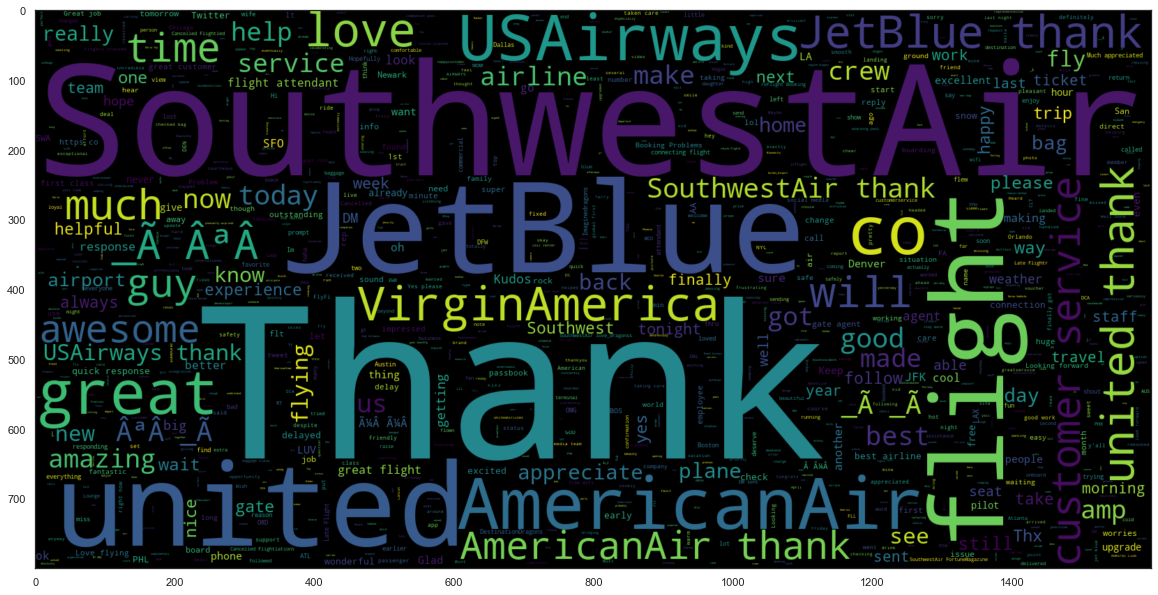

In [189]:
# Word Cloud for class 1
wc1 = exploratory_analysis(train_df[train_df['Target']==1])
wc1.word_cloud(wc1.data.Target)

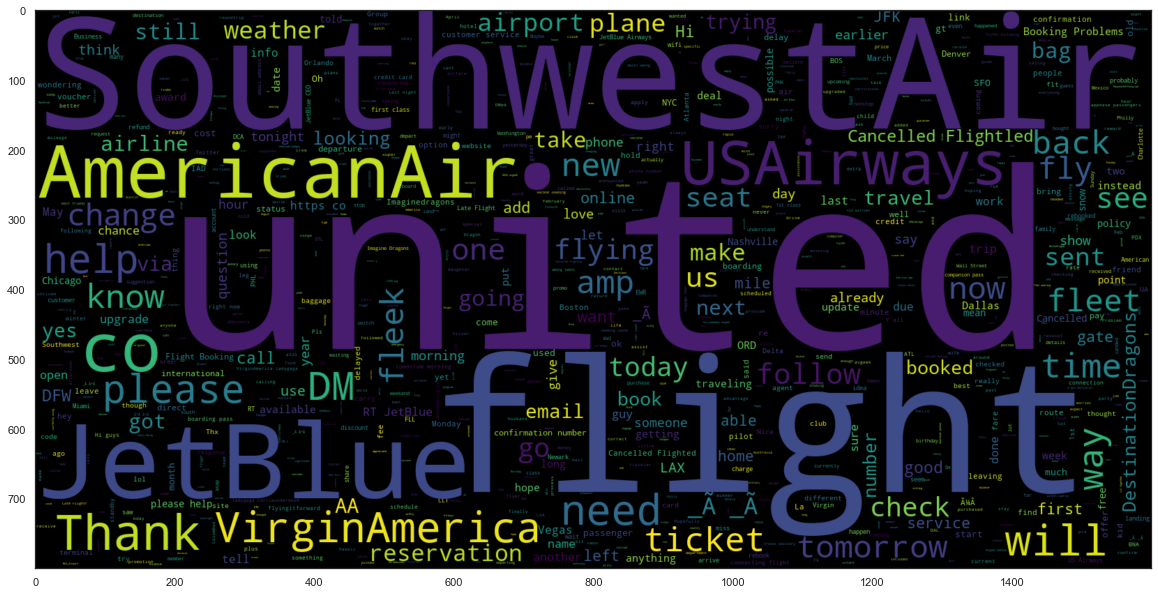

In [129]:
# Word Cloud for class 0
wc0 = exploratory_analysis(train_df[train_df['Target']==0])
wc0.word_cloud(wc0.data.Target)

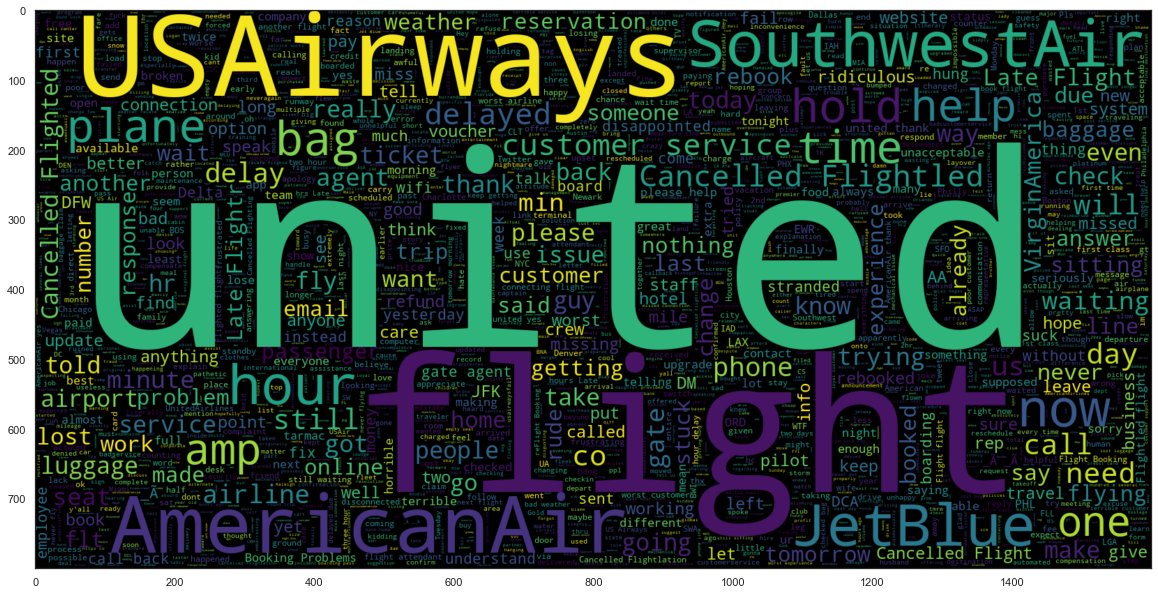

In [130]:
# Word Cloud for class -1
wc_1 = exploratory_analysis(train_df[train_df['Target']==-1])
wc_1.word_cloud(wc_1.data.Target)

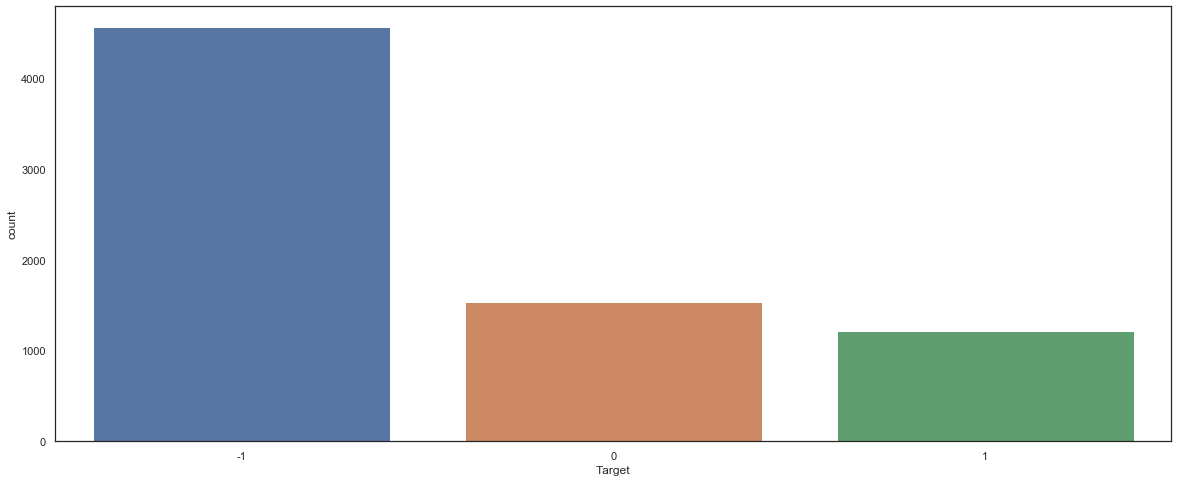

In [131]:
# Dist Plot
dist_plot = exploratory_analysis(train_df)
dist_plot.bar_plot()

## Data Preparation

In [195]:
train = data_division(train_df)
train_clean_df = train.denoise_text()
#train_x, test_x, train_y, test_y = data_division.train_test_division(train)

In [196]:
train_clean_df

'0 worst customer service 1 call wait times 20 minutes an2 whats random delay fl3 good morning wondering p4 ua 746 pacific rim date night cut 7315 followback7316 thanks help wish phone re7317 worst ever dca customerser7318 look another apology fly 7319 far worst airline 4 plname text length 7320 dtype object'

## Experimentation with various approaches

- Case 1 - TF-IDF Unigram Approach

In [35]:
train_X = sentiment_analysis.tf_idf_vect('word', 1, 1, 0.9, 1, None, stop_words=None, 
                                         Tokenizer = sentiment_analysis.stemming_tokenizer, 
                                         data_train=train_x, fit=True)
test_X  = sentiment_analysis.tf_idf_vect('word', 1, 1, 0.9, 1, None, stop_words=None, 
                                         Tokenizer = sentiment_analysis.stemming_tokenizer, 
                                         data=test_x, data_train=train_x, fit=False)

In [36]:
acc_xgb, f1_xgb = sentiment_analysis.xg_boost(train_X, train_y, test_X, test_y)
acc_nbc, f1_nbc = sentiment_analysis.naive_bayes(train_X, train_y, test_X, test_y)
acc_lrc, f1_lrc = sentiment_analysis.logistic_classifier(train_X, train_y, test_X, test_y)

- Case 2 - TF-IDF Bigram Approach

In [37]:
train_X = sentiment_analysis.tf_idf_vect('word', 2, 2, 0.9, 1, None, data_train=train_x, fit=True, 
                                         stop_words='english')
test_X  = sentiment_analysis.tf_idf_vect('word', 2, 2, 0.9, 1, None, data=test_x, data_train=train_x, fit=False, 
                                         stop_words='english')

In [38]:
acc_xgb_bi, f1_xgb_bi = sentiment_analysis.xg_boost(train_X, train_y, test_X, test_y)
acc_nbc_bi, f1_nbc_bi = sentiment_analysis.naive_bayes(train_X, train_y, test_X, test_y)
acc_lrc_bi, f1_lrc_bi = sentiment_analysis.logistic_classifier(train_X, train_y, test_X, test_y)

- Case 3 - Traditional BOW Approach (Unigram)

In [39]:
train_X = sentiment_analysis.count_vect('word', 1, 1, 0.9, 1, None, tokenizer=sentiment_analysis.lemmatize, 
                                        data_train=train_x, fit=True, stop_words='english')
test_X  = sentiment_analysis.count_vect('word', 1, 1, 0.9, 1, None, tokenizer=sentiment_analysis.lemmatize, 
                                        data=test_x, data_train=train_x, fit=False, stop_words='english')

In [40]:
acc_xgb_cnt, f1_xgb_cnt = sentiment_analysis.xg_boost(train_X, train_y, test_X, test_y)
acc_nbc_cnt, f1_nbc_cnt = sentiment_analysis.naive_bayes(train_X, train_y, test_X, test_y)
acc_lrc_cnt, f1_lrc_cnt = sentiment_analysis.logistic_classifier(train_X, train_y, test_X, test_y)

- Case 4 - Traditional BOW Approach (Bigram)

In [41]:
train_X = sentiment_analysis.count_vect('word', 2, 2, 0.9, 1, None, tokenizer=sentiment_analysis.lemmatize, 
                                        data_train=train_x, fit=True, stop_words='english')
test_X  = sentiment_analysis.count_vect('word', 2, 2, 0.9, 1, None, tokenizer=sentiment_analysis.lemmatize, 
                                        data=test_x, data_train=train_x, fit=False, stop_words='english')

In [42]:
acc_xgb_cnt_bi, f1_xgb_cnt_bi = sentiment_analysis.xg_boost(train_X, train_y, test_X, test_y)
acc_nbc_cnt_bi, f1_nbc_cnt_bi = sentiment_analysis.naive_bayes(train_X, train_y, test_X, test_y)
acc_lrc_cnt_bi, f1_lrc_cnt_bi = sentiment_analysis.logistic_classifier(train_X, train_y, test_X, test_y)

<b> Writing the results onto a dataframe or comparision. </b>

In [43]:
columns = ["Accuracy", "F1-Score"]

rows = ["XGB-TFIDF-Unigram", 
        "NBC-TFIDF-Unigram", 
        "LRC-TFIDF-Unigram",
        "XGB-TFIDF-Bigram", 
        "NBC-TFIDF-Bigram", 
        "LRC-TFIDF-Bigram", 
        "XGB-Count-Unigram", 
        "NBC-Count-Unigram", 
        "LRC-Count-Unigram", 
        "XGB-Count-BiGram", 
        "NBC-Count-BiGram", 
        "LRC-Count-BiGram"]

acc_data = pd.DataFrame({'Accuracy': [acc_xgb, acc_nbc, acc_lrc, acc_xgb_bi, acc_nbc_bi, 
                                      acc_lrc_bi, acc_xgb_cnt, acc_nbc_cnt, acc_lrc_cnt, 
                                      acc_xgb_cnt_bi, acc_nbc_cnt_bi, acc_lrc_cnt_bi]}, index = rows)
f1_data = pd.DataFrame({'F1-Score': [f1_xgb, f1_nbc ,f1_lrc, f1_xgb_bi, f1_nbc_bi, 
                                     f1_lrc_bi, f1_xgb_cnt, f1_nbc_cnt, f1_lrc_cnt, 
                                     f1_xgb_cnt_bi, f1_nbc_cnt_bi, f1_lrc_cnt_bi]}, index = rows)

performance_df = pd.concat([acc_data, f1_data], axis=1)
performance_df

,Accuracy,F1-Score
XGB-TFIDF-Unigram,0.788707,0.725277
NBC-TFIDF-Unigram,0.646630,0.366959
LRC-TFIDF-Unigram,0.797814,0.720658
XGB-TFIDF-Bigram,0.658470,0.468248
NBC-TFIDF-Bigram,0.655738,0.404313
LRC-TFIDF-Bigram,0.660291,0.424098
XGB-Count-Unigram,0.770492,0.690770
NBC-Count-Unigram,0.750455,0.635276
LRC-Count-Unigram,0.794171,0.724309
XGB-Count-BiGram,0.663934,0.454908


From the above 4 Cases, we see that the Traditional Bag of Words using <b> Count Vectorizer and OneVsAll Logistic Classifier</b> gave us a testing accuracy of <b>0.81</b> and Macro F1 Score of <b>0.74</b> . We now try Grid Search CV across various hyper-parameters and then use Cross Validation to measure the performance across various train test splits.

## Grid-Search CV for estimating the best hyper-parameters

In [46]:
gs, best_estimator_ = sentiment_analysis.grid_search_hyper(train_x, train_y)

C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Total Execution Time -  606.8556914329529
Best Training Macro F1-Score -  0.7978142076502732
Best Training Params -  {'vec__max_df': 0.8, 'vec__min_df': 1, 'vec__tokenizer': <function sentiment_analysis.lemmatize at 0x0000019559293B88>}


Using Grid Search CV, We found that the Best Hyperparamters for OneVsRestClassifier are 'vec__max_df': 0.8, 'vec__min_df': 1 with Training f1-Score of 0.7692

In [69]:
test_pred = best_estimator_.predict(test_x)
print('Testing Macro F1-Score - ',f1_score(test_pred, test_y, average='macro'))

Testing Macro F1-Score -  0.7507698534812018


In [70]:
print('Testing Accuracy - ',accuracy_score(test_pred, test_y))

Testing Accuracy -  0.8060109289617486


## Cross-Validation for estimating the F-1 Score across the dataset.

Now, we use the above classifier and use Cross Validation to check the performance against various train-test splits using Cross Validation

In [52]:
skfold = StratifiedKFold(n_splits=6,random_state=42)
results_skfold = cross_val_score(best_estimator_,train_x, train_y,scoring='f1_macro')
print('Average K-Fold CV F1-Score - ',results_skfold.mean())

C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Average K-Fold CV F1-Score -  0.7316386588298275


# Predictions on DataSet without pre-defined classes.

In [53]:
test_df.head(5)

,id,text
0,7322,@AmericanAir In car gng to DFW. Pulled over 1h...
1,7323,"@AmericanAir after all, the plane didnÂÃÂªt ..."
2,7324,@SouthwestAir can't believe how many paying cu...
3,7325,@USAirways I can legitimately say that I would...
4,7326,@AmericanAir still no response from AA. great ...


In [97]:
# Predictions on test file
test_x   = data_division(test_df['text'])
cleaned_ = data_division.denoise_text(test_x.data)
target_  = sentiment_analysis.get_predictions(test_x.data, best_estimator_)
test_df['Cleaned_Text'] = test_x.data
test_df['Target']       = target_
test_df.head(5)

C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:155: FutureWarning: Series.data is deprecated and will be removed in a future version


,id,text,Cleaned_Text,Target
0,7322,@AmericanAir In car gng to DFW. Pulled over 1h...,@AmericanAir In car gng to DFW. Pulled over 1h...,-1
1,7323,"@AmericanAir after all, the plane didnÂÃÂªt ...","@AmericanAir after all, the plane didnÂÃÂªt ...",0
2,7324,@SouthwestAir can't believe how many paying cu...,@SouthwestAir can't believe how many paying cu...,-1
3,7325,@USAirways I can legitimately say that I would...,@USAirways I can legitimately say that I would...,0
4,7326,@AmericanAir still no response from AA. great ...,@AmericanAir still no response from AA. great ...,1


In [70]:
# Writing the prediction to a file
predictions.to_csv('Sentiment_Predictions.csv')

# <b>Conclusion</b>

- In order to predict the Sentiment of the Tweets, we used Traditional Machine Learning Algorithms. We started with cleaning the tweets using regular expressions. Then we tokenized the data, used Stemming and Lemmatization along with Count Vectorizer, and TF-IDF Vectorizer. 
- Once the training data was represented using the above techniques, we used Multinomial Naive Bayes, XGBoost, and Logistic Regression One Vs All. 
- After experimentation, the best results was obtained with CountVectorizer (Unigrams). Grid Search was used to search for the best hyper-parameters. 
- Then we used Cross Validation to evaluate the performance of the best classifier across the entire dataset. The average F1-Macro CV Score was 0.71 which was very close to the testing F1-Score of the best model. This helped us ensure that our model would score closely to this value across various real time datasets.